## ☀️ Importing Libraries

In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from random import shuffle
from sklearn import model_selection as sk_model_selection

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC

import tensorflow as tf


2021-09-20 20:45:42.453341: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Loading Data

In [2]:
data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
pytorch3dpath = "../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D"
 
mri_types = ['FLAIR','T1w','T1wCE','T2w']
mri_types_id=0 # 0,1,2,3

IMAGE_SIZE = 150
NUM_IMAGES = 128
BATCH_SIZE= 4

num_folds=5
Selected_fold=1 #1,2,3,4,5 

train_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
train_df['BraTS21ID5'] = [format(x, '05d') for x in train_df.BraTS21ID]
train_df["Fold"]="train"
train_df.head(5)

# For debug
#train_df=train_df.head(n=40)

,BraTS21ID,MGMT_value,BraTS21ID5,Fold
0,0,1,00000,train
1,2,1,00002,train
2,3,0,00003,train
3,5,1,00005,train
4,6,1,00006,train


In [3]:
sample_submission = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')
test=sample_submission
test['BraTS21ID5'] = [format(x, '05d') for x in test.BraTS21ID]
test.head(3)

,BraTS21ID,MGMT_value,BraTS21ID5
0,1,0.5,00001
1,13,0.5,00013
2,15,0.5,00015


# Functions to load images


(1, 150, 150, 512)
0.0 1.0 0.22125804911014837 0.0005073431211959514
Dimension of the CT scan is: (150, 150, 512)


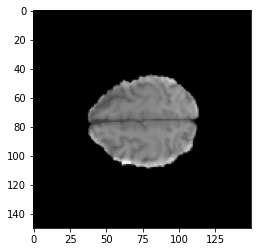

In [4]:
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=IMAGE_SIZE, mri_type=mri_types[mri_types_id], split="train", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

# ALL MRI TYPES ONCE
def load_all_types_imgs_3d(scan_id, mri_types=mri_types, split="train", rotate=0, shuffle=True):
    imgs3d_ = [load_dicom_images_3d(scan_id=scan_id, mri_type=x, split=split, rotate=rotate) for x in mri_types]
    imgs3d = np.concatenate((imgs3d_), axis = -1)
    
    if shuffle:
        X = imgs3d
        #np.random.seed(SEED)
        return np.take(X, np.random.rand(X.shape[-1]).argsort(), axis=-1, out=X)
    
    return imgs3d

a = load_all_types_imgs_3d("00000")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 256,]), cmap="gray")

In [5]:
# def plot_slices(num_rows, num_columns, width, height, data):
#     """Plot a montage of 20 CT slices"""
#     data = np.rot90(np.array(data))  
#     data = np.transpose(data)
#     data = np.reshape(data, (num_rows, num_columns, width, height))
#     rows_data, columns_data = data.shape[0], data.shape[1]
#     heights = [slc[0].shape[0] for slc in data]
#     widths = [slc.shape[1] for slc in data[0]]
#     fig_width = 12.0
#     fig_height = fig_width * sum(heights) / sum(widths)
#     f, axarr = plt.subplots(
#         rows_data,
#         columns_data,
#         figsize=(fig_width, fig_height),
#         gridspec_kw={"height_ratios": heights},
#     )
#     for i in range(rows_data):
#         for j in range(columns_data):
#             axarr[i, j].imshow(data[i][j], cmap="gray")
#             axarr[i, j].axis("off")
#     plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
#     plt.show()
# # Visualize montage of slices.
# # 5 rows and 10 columns for 100 slices of the CT scan.
# plot_slices(5, 10, IMAGE_SIZE, IMAGE_SIZE, image[:, :, :50])

# Folds

In [6]:
# from sklearn.model_selection import KFold,StratifiedKFold
# sfolder = StratifiedKFold(n_splits=5,random_state=13,shuffle=True)
# X = train_df[['BraTS21ID']]
# y = train_df[['MGMT_value']]

# fold_no = 1
# for train, valid in sfolder.split(X,y):
#     if fold_no==Selected_fold:
#         train_df.loc[valid, "Fold"] = "valid"
#     fold_no += 1

In [7]:
df_train=train_df[train_df.Fold=="train"]
df_valid=train_df[train_df.Fold=="valid"]
print("df_train=",len(df_train),"-- df_valid=",len(df_valid))

df_train= 585 -- df_valid= 0


In [8]:
samples_to_exclude = [109, 123, 709]

df_train = df_train[~df_train.BraTS21ID.isin(samples_to_exclude)]
df_train

,BraTS21ID,MGMT_value,BraTS21ID5,Fold
0,0,1,00000,train
1,2,1,00002,train
2,3,0,00003,train
3,5,1,00005,train
4,6,1,00006,train
...,...,...,...,...
580,1005,1,01005,train
581,1007,1,01007,train
582,1008,1,01008,train
583,1009,0,01009,train


#  Custom Data Generator

In [9]:
from tensorflow.keras.utils import Sequence
class Dataset(Sequence):
    def __init__(self,df,is_train=True,batch_size=BATCH_SIZE,shuffle=True):
        self.idx = df["BraTS21ID"].values
        self.paths = df["BraTS21ID5"].values
        self.y =  df["MGMT_value"].values
        self.is_train = is_train
        self.batch_size = batch_size
        self.shuffle = shuffle
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
   
    def __getitem__(self,ids):
        id_path= self.paths[ids]
        batch_paths = self.paths[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
        
        if self.is_train:
            list_x =  [load_all_types_imgs_3d(x,split="train") for x in batch_paths]
            batch_X = np.stack(list_x, axis=4)
            return batch_X,batch_y
        else:
            list_x =  load_all_types_imgs_3d(id_path,split="test")#str(scan_id).zfill(5)
            batch_X = np.stack(list_x)
            return batch_X
    
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.idx, self.paths, self.y))
            shuffle(ids_y)
            self.idx, self.paths, self.y = list(zip(*ids_y))


In [10]:
train_dataset = Dataset(df_train,batch_size=BATCH_SIZE)
# valid_dataset = Dataset(df_valid,batch_size=BATCH_SIZE)

Dimension of the CT scan is: (1, 150, 150, 512, 4)
label= [1 1 0 1]


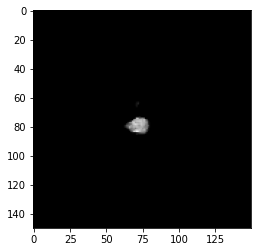

In [11]:
for i in range(1):
    images, label = train_dataset[i]
    print("Dimension of the CT scan is:", images.shape)
    print("label=",label)
    plt.imshow(images[0,:,:,0,0], cmap="gray")
    plt.show()

# Model

In [12]:
def get_model(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=512):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))
     
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.01)(x)
    
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.02)(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.03)(x)

    x = layers.Conv3D(filters=512, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.04)(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=1024, activation="relu")(x)
    x = layers.Dropout(0.08)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")

    return model

# Build model.
model = get_model(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=512)
model.summary()

2021-09-20 20:46:08.655821: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-20 20:46:08.658632: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-20 20:46:08.707037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 20:46:08.707769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-20 20:46:08.707847: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-20 20:46:08.743911: I tensorflow/stream_executor/platform/def

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 512, 1) 0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 148, 148, 510, 64) 1792      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 74, 74, 255, 64)   0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 74, 74, 255, 64)   256       
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 255, 64)   0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 72, 72, 253, 128)  221312    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 36, 36, 126, 128)  0     

In [13]:
# Compile model.
initial_learning_rate = 0.003
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=False
)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[AUC(name='auc'),"acc"],
)
# Define callbacks.
model_save = ModelCheckpoint('Brain_3d all_MRI_types no_fold.h5', 
                             save_best_only = True, 
                             monitor = 'loss', 
                             mode = 'min', verbose = 1,
                             save_weights_only = False)
early_stop = EarlyStopping(monitor = 'loss', 
                           patience = 10, mode = 'min', verbose = 1,
                           restore_best_weights = True)

# Train the model, doing validation at the end of each epoch
epochs = 15
history = model.fit(
    train_dataset,
#     validation_data=valid_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks = [model_save, early_stop] #early_stop
)

2021-09-20 20:46:19.494500: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-20 20:46:19.498564: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


Epoch 1/15


2021-09-20 20:46:20.987875: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-20 20:46:21.853109: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-20 20:46:42.017702: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


146/146 [==============================] - 2104s 14s/step - loss: 0.7076 - auc: 0.4716 - acc: 0.5316

Epoch 00001: loss improved from inf to 0.70166, saving model to Brain_3d all_MRI_types no_fold.h5
Epoch 2/15
146/146 [==============================] - 2156s 15s/step - loss: 0.6955 - auc: 0.4585 - acc: 0.4832

Epoch 00002: loss improved from 0.70166 to 0.69430, saving model to Brain_3d all_MRI_types no_fold.h5
Epoch 3/15
146/146 [==============================] - 2154s 15s/step - loss: 0.6932 - auc: 0.4533 - acc: 0.5351

Epoch 00003: loss improved from 0.69430 to 0.69372, saving model to Brain_3d all_MRI_types no_fold.h5
Epoch 4/15
146/146 [==============================] - 2191s 15s/step - loss: 0.6927 - auc: 0.4730 - acc: 0.5323

Epoch 00004: loss improved from 0.69372 to 0.69342, saving model to Brain_3d all_MRI_types no_fold.h5
Epoch 5/15
146/146 [==============================] - 2174s 15s/step - loss: 0.6912 - auc: 0.4707 - acc: 0.5469

Epoch 00005: loss improved from 0.69342 to

# Visualizing model performance

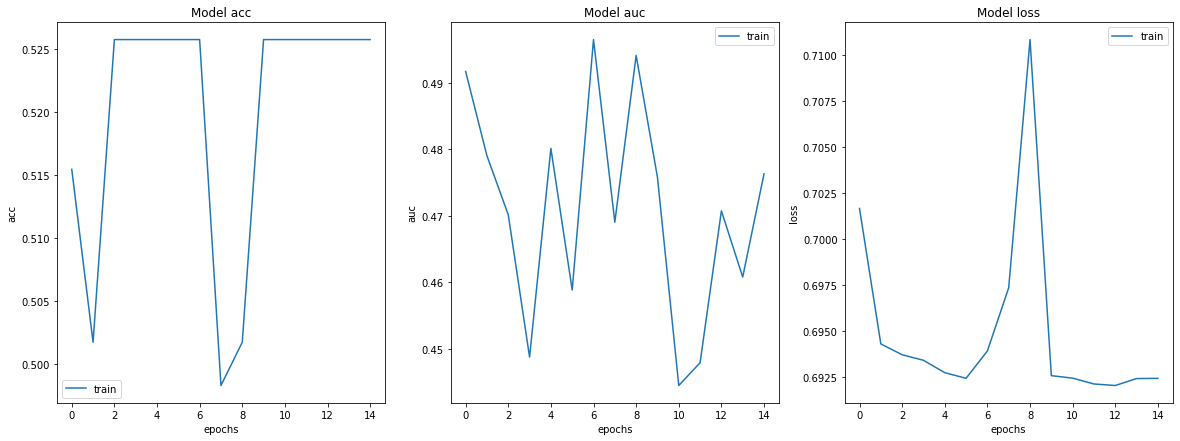

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax = ax.ravel()

for i, metric in enumerate(["acc","auc","loss"]):
    ax[i].plot(model.history.history[metric])
#     ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train"])#, "val"

# Make predictions

Dimension of the CT scan is: (1, 150, 150, 512)


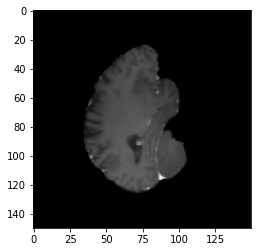

In [15]:
test_dataset = Dataset(test,is_train=False,batch_size=1)


for i in range(1):
    image = test_dataset[i]
    print("Dimension of the CT scan is:", image.shape)
    plt.imshow(image[0,:,:, 32], cmap="gray")
    plt.show()

In [16]:
preds = model.predict(test_dataset)
preds = preds.reshape(-1)

In [17]:
preds

array([0.3317059 , 0.5493555 , 0.3328164 , 0.58059335, 0.51788217,
       0.625228  , 0.63595206, 0.6459956 , 0.35649735, 0.5632793 ,
       0.8600965 , 0.83575773, 0.84978384, 0.78034586, 0.79749936,
       0.7308867 , 0.6879892 , 0.6969776 , 0.60385   , 0.63006026,
       0.6462681 , 0.8546543 , 0.6568019 , 0.61001885, 0.6252488 ,
       0.68894917, 0.7315573 , 0.61179453, 0.6381596 , 0.715304  ,
       0.6487555 , 0.84828466, 0.6201022 , 0.65085524, 0.7143363 ,
       0.6987447 , 0.69876415, 0.7175782 , 0.74684024, 0.5742453 ,
       0.67244536, 0.6844434 , 0.7580015 , 0.6694129 , 0.7241427 ,
       0.48761734, 0.6036726 , 0.47620228, 0.73488617, 0.83531547,
       0.11128812, 0.79684764, 0.83216274, 0.7680217 , 0.8172764 ,
       0.8179916 , 0.7665531 , 0.51325047, 0.62792283, 0.7886211 ,
       0.60341495, 0.7606783 , 0.5285926 , 0.46658176, 0.7307315 ,
       0.78050584, 0.7771437 , 0.80500793, 0.7811704 , 0.6334255 ,
       0.6805332 , 0.81566817, 0.7275406 , 0.79098487, 0.74738

In [18]:
submission = pd.DataFrame({'BraTS21ID':sample_submission['BraTS21ID'],'MGMT_value':preds})
submission

,BraTS21ID,MGMT_value
0,1,0.331706
1,13,0.549356
2,15,0.332816
3,27,0.580593
4,37,0.517882
...,...,...
82,826,0.668564
83,829,0.864979
84,833,0.634285
85,997,0.788078


In [19]:
submission.to_csv('submission.csv',index=False)

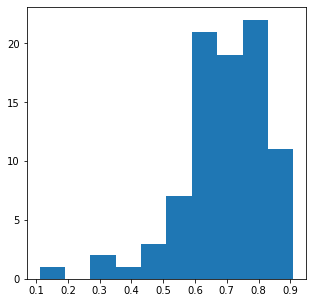

In [20]:
plt.figure(figsize=(5, 5))
plt.hist(submission["MGMT_value"]);